# EE519 — Lecture 9 (Linear Prediction / LPC) — Notebook 9.1
## LPC from scratch + FFT vs envelope (fixed overlays)

**Theme:** Core LPC analysis with corrected Toeplitz usage and better FFT-envelope comparison plots.

---
### 🧭 In-class workflow
1. Read the short explanation above each code cell
2. Predict what you expect to see
3. Run
4. Save at least one key figure

### 🧯 Debugging quick panel (“If you see X, do Y”)
- **Module import error** → run the “Environment & imports” cell again; restart kernel if needed.
- **Audio playback is silent** → re-record closer to mic; ensure waveform peak is not near zero.
- **`frame_selections` missing** → go back to Notebook 9.0 and define time ranges / frames, then save to manifest.
- **LPC envelope looks too wiggly** → reduce order `p` (try 10–16).
- **LPC envelope looks too flat** → increase order `p` slightly or pick a steadier vowel region.
- **FFT vs LPC don’t “overlay”** → use the provided “normalize-to-peak” plot (shape comparison) cell.


### 🎯 Learning goals
- Run end-to-end without manual clip/frame prompts (assumes Notebook 9.0 selections saved)
- Save key plots to the project folder


## 0. Environment & imports (run this first)

This notebook uses:
- `numpy`, `matplotlib`
- `scipy` (signal + linalg)
- optional: `sounddevice` (recording)
- optional: `sklearn` (mini ML demo only)

If any import fails, the cell prints what to do next.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Core scipy imports (required)
try:
    import scipy.signal as sig
    import scipy.linalg as la
    import scipy.io.wavfile as wavfile
    SCIPY_OK = True
    print("scipy imports: ✅")
except Exception as e:
    SCIPY_OK = False
    print("scipy imports: ❌")
    print("Error:", e)

# Optional recording
try:
    import sounddevice as sd
    HAS_SD = True
    print("sounddevice: ✅ (recording enabled)")
except Exception as e:
    HAS_SD = False
    print("sounddevice: ❌ (recording disabled)")

from pathlib import Path
import json, os, time
from IPython.display import Audio, display


scipy imports: ✅
sounddevice: ✅ (recording enabled)


## 1. Project + manifest workflow (same spirit as Lectures 7/8)

We will use one project folder:
```
EE519_L9_Project/
  recordings/
  figures/
  features/
  cache/
  manifest.json
```

✅ You can re-run this cell any time safely.


In [2]:
PROJECT_DIR = Path("EE519_L9_Project")
REC_DIR = PROJECT_DIR / "recordings"
FIG_DIR = PROJECT_DIR / "figures"
FEAT_DIR = PROJECT_DIR / "features"
CACHE_DIR = PROJECT_DIR / "cache"

for d in [PROJECT_DIR, REC_DIR, FIG_DIR, FEAT_DIR, CACHE_DIR]:
    d.mkdir(parents=True, exist_ok=True)

MANIFEST_PATH = PROJECT_DIR / "manifest.json"

def load_manifest():
    if MANIFEST_PATH.exists():
        return json.loads(MANIFEST_PATH.read_text())
    return {"clips": [], "meta": {"created": time.time(), "course":"EE519", "lecture":9}}

def save_manifest(m):
    MANIFEST_PATH.write_text(json.dumps(m, indent=2))

manifest = load_manifest()
print("Manifest clips:", len(manifest["clips"]))
print("Project dir:", PROJECT_DIR.resolve())


Manifest clips: 9
Project dir: C:\Users\K\Documents\usc\ee519\ee519-lecture\lecture10\EE519_L9_Project


## 2. Utilities (audio I/O, framing, STFT, saving figures)

These helpers are used throughout Lecture 9 notebooks.


In [3]:
def read_wav(path):
    fs, x = wavfile.read(path)
    x = x.astype(np.float32)
    if x.ndim > 1:
        x = x.mean(axis=1)
    if np.max(np.abs(x)) > 1.5:
        x = x / 32768.0
    return fs, x

def peak_normalize(x, target=0.95):
    m = np.max(np.abs(x)) + 1e-12
    return x * (target / m)

def play_audio(x, fs, label=""):
    print(label, f"(fs={fs}, length={len(x)/fs:.2f}s)")
    display(Audio(x, rate=fs))

def savefig(name):
    out = FIG_DIR / name
    plt.savefig(out, dpi=180, bbox_inches="tight")
    print("Saved:", out)

def hann(N):
    return np.hanning(N).astype(np.float32)

def frame_signal(x, N, H):
    if len(x) < N:
        raise ValueError("Signal shorter than frame length N.")
    num = 1 + (len(x) - N) // H
    frames = np.stack([x[i*H:i*H+N] for i in range(num)], axis=0)
    return frames

def stft_scipy(x, fs, win_ms=25, hop_ms=10, nfft=None, window="hann"):
    N = int(win_ms * 1e-3 * fs)
    H = int(hop_ms * 1e-3 * fs)
    if nfft is None:
        nfft = 1 << int(np.ceil(np.log2(N)))
    f, t, Z = sig.stft(x, fs=fs, window=window, nperseg=N, noverlap=N-H, nfft=nfft, boundary=None, padded=False)
    return f, t, Z, N, H

def plot_spectrogram(Z, fs, title, fmax=8000):
    S = 20*np.log10(np.abs(Z)+1e-12)
    plt.figure(figsize=(10,4))
    plt.imshow(S, origin="lower", aspect="auto",
               extent=[0, Z.shape[1], 0, fs/2])
    plt.ylim([0, fmax])
    plt.colorbar(label="dB")
    plt.title(title)
    plt.xlabel("Frame index")
    plt.ylabel("Frequency (Hz)")
    plt.show()


## LPC core functions (used in Notebooks 9.1–9.4)

### Important fix vs earlier versions
- `toeplitz` is in `scipy.linalg`, not `scipy.signal`.
- We therefore use `la.toeplitz` to avoid errors.

### Autocorrelation convention
We use a **biased** autocorrelation estimate:
\$
r[k] = \sum_{n=0}^{N-1-k} x[n]\,x[n+k]
\$

This is common in LPC autocorrelation method demonstrations.


In [4]:
def autocorr_biased(x, p):
    x = np.asarray(x, dtype=np.float64)
    r = np.zeros(p+1, dtype=np.float64)
    for k in range(p+1):
        r[k] = np.sum(x[:len(x)-k] * x[k:])
    return r

def lpc_autocorr_method(x, p):
    r = autocorr_biased(x, p)
    R = la.toeplitz(r[:-1])  # r[0..p-1]
    rhs = -r[1:]
    a = np.linalg.solve(R + 1e-12*np.eye(p), rhs)
    return a, r

def lpc_residual(x, a):
    A = np.concatenate([[1.0], a])
    e = sig.lfilter(A, [1.0], x)
    return e

def lpc_envelope_db(a, fs, nfft=4096):
    A = np.concatenate([[1.0], a])
    # Use freqz (stable, consistent)
    w, h = sig.freqz([1.0], A, worN=nfft, fs=fs)
    env_db = 20*np.log10(np.abs(h)+1e-12)
    return w, env_db

def fft_mag_db(x, fs, nfft=4096):
    X = np.fft.rfft(x, n=nfft)
    f = np.fft.rfftfreq(nfft, 1/fs)
    mag_db = 20*np.log10(np.abs(X)+1e-12)
    return f, mag_db

def normalize_to_peak(y_db):
    return y_db - np.max(y_db)


## Load a clip that already has `frame_selections`

✅ If this errors, go back to **Notebook 9.0**, select time ranges, and save to manifest.


In [5]:
def pick_first_clip_with_selections(prefer_label="vowel"):
    m = load_manifest()
    # first try preferred label
    for i,c in enumerate(m["clips"]):
        if c.get("label")==prefer_label and "frame_selections" in c and len(c["frame_selections"].get("vowel_frames",[]))>0:
            return i,c,m
    # otherwise any with selections
    for i,c in enumerate(m["clips"]):
        if "frame_selections" in c:
            return i,c,m
    raise RuntimeError("No clip has frame_selections. Run Notebook 9.0 to select and save frames.")

CLIP_IDX, clip, manifest = pick_first_clip_with_selections("vowel")
print("Using clip:", CLIP_IDX, clip["filename"], "| label:", clip.get("label"))

fs, x = read_wav(REC_DIR / clip["filename"])
x = peak_normalize(x)

sel = clip["frame_selections"]
WIN_MS = sel.get("win_ms", 25)
HOP_MS = sel.get("hop_ms", 10)
N = int(WIN_MS*1e-3*fs)
H = int(HOP_MS*1e-3*fs)

frames = frame_signal(x, N, H) * hann(N)[None,:]
vowel_frames = sel.get("vowel_frames", [])
fric_frames = sel.get("fricative_frames", [])
sil_frames = sel.get("silence_frames", [])

print("Counts | vowel:", len(vowel_frames), "fric:", len(fric_frames), "sil:", len(sil_frames))


Using clip: 6 F01_fric_s.wav | label: fricative
Counts | vowel: 30 fric: 10 sil: 4


### 🔧 Practical audio conditioning (recommended)
Two small steps often make LPC envelopes cleaner:

1) **DC removal**: removes microphone offset  
2) **Pre-emphasis**: boosts high frequencies so the envelope is more balanced

You can toggle this on/off to see the effect.


In [6]:
USE_PREEMPH = True
PREEMPH_ALPHA = 0.97

if USE_PREEMPH:
    x = x - np.mean(x)
    x = sig.lfilter([1, -PREEMPH_ALPHA], [1], x)
    x = peak_normalize(x)
    print("Applied DC removal + pre-emphasis.")
else:
    print("Skipped pre-emphasis.")


Applied DC removal + pre-emphasis.


## LPC on one vowel frame + residual

We pick the first vowel frame stored in the manifest.


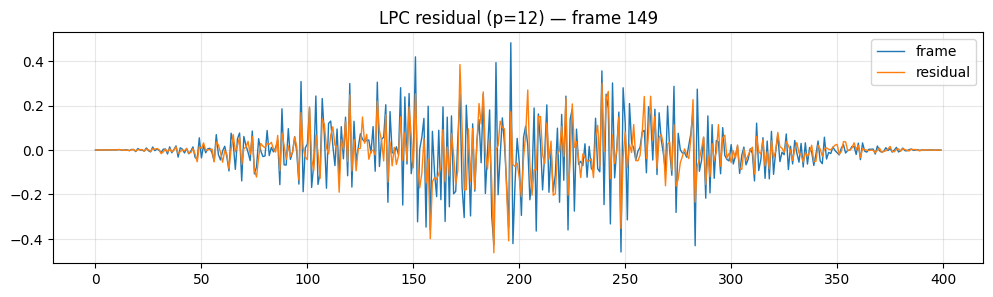

Saved: EE519_L9_Project\figures\L9_1_residual_p12_frame149.png


<Figure size 640x480 with 0 Axes>

In [7]:
FRAME_IDX = vowel_frames[0]
xf = frames[FRAME_IDX].astype(np.float64)

p = 12
a, r = lpc_autocorr_method(xf, p)
e = lpc_residual(xf, a)

plt.figure(figsize=(12,3))
plt.plot(xf, label="frame", linewidth=1.0)
plt.plot(e, label="residual", linewidth=1.0)
plt.title(f"LPC residual (p={p}) — frame {FRAME_IDX}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
savefig(f"L9_1_residual_p{p}_frame{FRAME_IDX}.png")


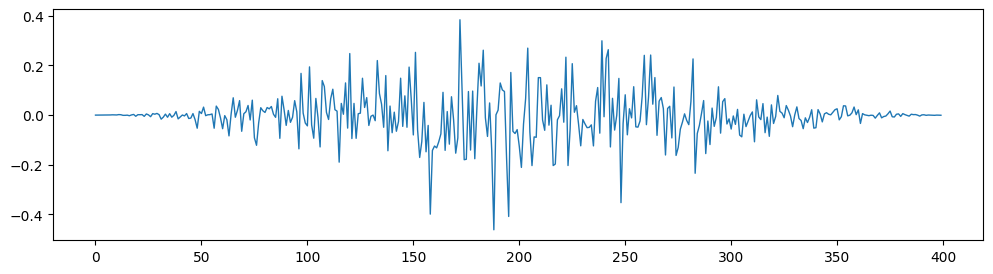

In [8]:
plt.figure(figsize=(12,3))
plt.plot(e, label="residual", linewidth=1.0)

### 🎧 Listen to the residual (very important intuition)
- For a **vowel**, residual should sound like a buzzy excitation (pitch pulses).
- For a **fricative**, residual often resembles noise (because the model is mismatched).


In [9]:
# Listen to residual (short)
play_audio(e.astype(np.float32), fs, label="LPC residual (listen)")


LPC residual (listen) (fs=16000, length=0.03s)


## FFT vs LPC envelope (two plots)

### Plot A: raw dB (absolute scale)
Good for “true levels”, but can have offsets due to window/FFT scaling.

### Plot B: normalized-to-peak (shape comparison)
This is what you want when teaching “envelope matches FFT shape”.


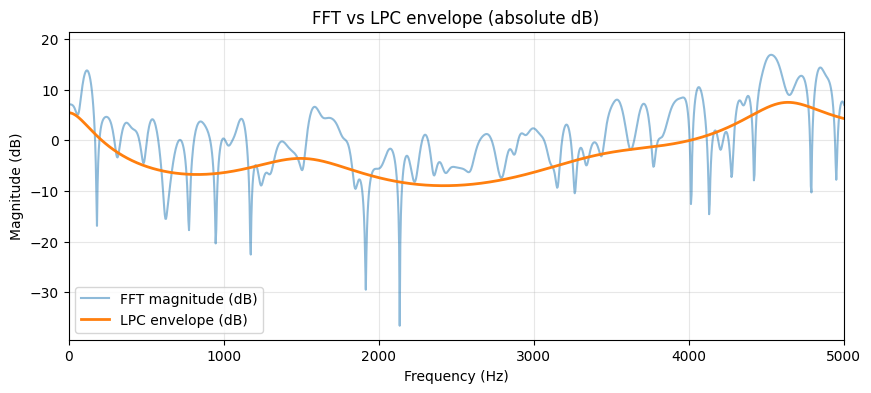

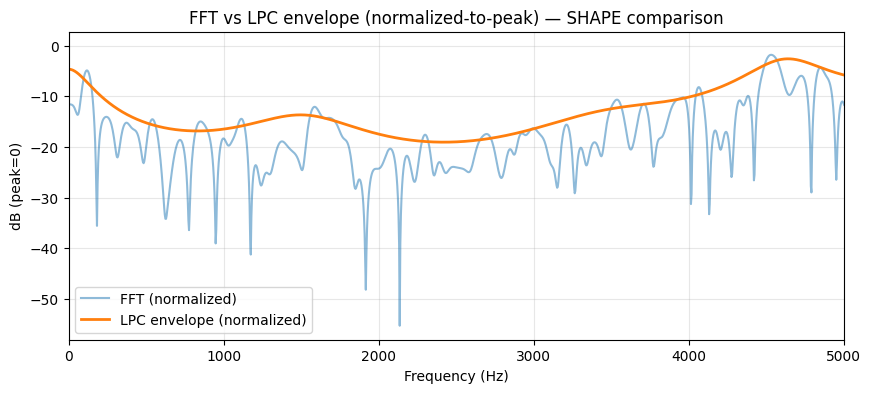

Saved: EE519_L9_Project\figures\L9_1_fft_vs_lpc_norm_p12_frame149.png


<Figure size 640x480 with 0 Axes>

In [10]:
NFFT = 4096
f, mag_fft = fft_mag_db(xf, fs, nfft=NFFT)
w, env_db = lpc_envelope_db(a, fs, nfft=NFFT)

plt.figure(figsize=(10,4))
plt.plot(f, mag_fft, alpha=0.5, label="FFT magnitude (dB)")
plt.plot(w, env_db, linewidth=2.0, label="LPC envelope (dB)")
plt.xlim([0, 5000])
plt.title("FFT vs LPC envelope (absolute dB)")
plt.xlabel("Frequency (Hz)"); plt.ylabel("Magnitude (dB)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(f, normalize_to_peak(mag_fft), alpha=0.5, label="FFT (normalized)")
plt.plot(w, normalize_to_peak(env_db), linewidth=2.0, label="LPC envelope (normalized)")
plt.xlim([0, 5000])
plt.title("FFT vs LPC envelope (normalized-to-peak) — SHAPE comparison")
plt.xlabel("Frequency (Hz)"); plt.ylabel("dB (peak=0)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

savefig(f"L9_1_fft_vs_lpc_norm_p{p}_frame{FRAME_IDX}.png")


## Order sweep (visual intuition)

✅ Use this to show when LPC starts to overfit harmonics.


### 📌 Practical LPC order rule-of-thumb (speech)
For 16 kHz speech, a common heuristic is:
\begin{align}
p \approx 2 + \frac{f_s}{1000}
\end{align}
So at \(f_s=16\text{kHz}\), \(p \approx 18\).

**In practice for this class:** try **12–18** for vowels.  
Avoid going beyond ~24 unless you are intentionally demonstrating overfitting.


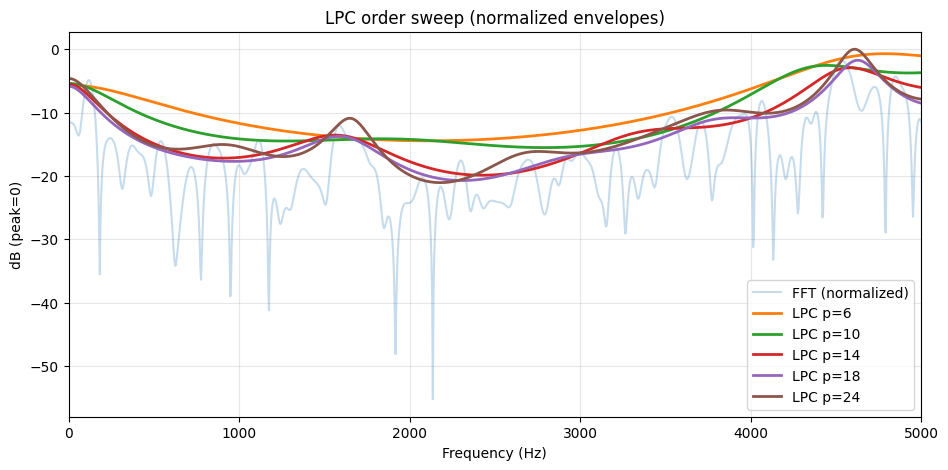

Saved: EE519_L9_Project\figures\L9_1_lpc_order_sweep_norm_frame149.png


<Figure size 640x480 with 0 Axes>

In [11]:
orders = [6, 10, 14, 18, 24]
plt.figure(figsize=(11,5))
plt.plot(f, normalize_to_peak(mag_fft), alpha=0.25, label="FFT (normalized)")
for p in orders:
    a,_ = lpc_autocorr_method(xf, p)
    w, env_db = lpc_envelope_db(a, fs, nfft=NFFT)
    plt.plot(w, normalize_to_peak(env_db), linewidth=2.0, label=f"LPC p={p}")
plt.xlim([0, 5000])
plt.title("LPC order sweep (normalized envelopes)")
plt.xlabel("Frequency (Hz)"); plt.ylabel("dB (peak=0)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()
savefig(f"L9_1_lpc_order_sweep_norm_frame{FRAME_IDX}.png")


---
## ✅ What you learned (Notebook 9.1)
- You ran the LPC pipeline without fighting imports/toeplitz errors.
- You compared FFT vs LPC envelope using a **normalized-to-peak** plot (shape match).
- You saved figures into the project folder for later slides/reports.

## ➡️ What’s next
Proceed to **Notebook 9.2** (Levinson–Durbin + PARCOR).


---
## 🧠 Reflection (Notebook 9.1)

### What you learned
- How LPC arises from minimizing prediction error.
- How the LPC residual behaves on voiced frames.
- How and why LPC produces a smooth spectral envelope.
- Why FFT-vs-LPC overlays can look “offset” in dB, and why normalized-to-peak is best for envelope shape comparison.

### Common mistakes to notice (and fix next time)
- Choosing too high an LPC order → envelope starts tracking harmonics (“overfitting”).
- Comparing absolute dB scales and assuming mismatch → instead compare shape (normalized plot).
- Using a fricative/noisy frame but expecting vowel-like formant envelope.

### Reflective questions
1. In your order sweep, what changed as `p` increased? Where did it start to overfit?
2. How does the LPC residual differ between a vowel and a fricative frame (qualitatively)?
3. Why is it reasonable that the LPC envelope captures formants more than harmonics?
4. If you had to pick a default order for 16 kHz speech, what would you choose and why?

### Quick self-check
- [ ] I can explain the role of the prediction error (residual).
- [ ] I can justify a reasonable LPC order for vowels.
- [ ] I saved the normalized FFT-vs-LPC overlay plot.


### Answers

1. The spectral envelope can be represented more detailed but if we increase to far (~24) we can see overfitting.
2. The fricative looks more like noise while the vowel has peaks that seem periodic.
3. LPC approximates the shape and vowels will have harmonic spikes so it will not capture this.
4. 18 would probably be best since it was the highest that didn't overfit.